In [2]:
import numpy as np
import json 
import pandas as pd
import svgwrite
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [10]:
class letter:
    def init(character, serif = False, ppper=False, cursive=False):
        self.character = character
        self.serif = serif
        self.upper = upper
        self.cursive = cursive 
        
    def getTrajectory():
        return # access from database

In [11]:
class word:
    def init(characterList):
        self.characterList = characterList
        
    def getTranjectory():
        return #compiled trajectories for each letter in word connecting when cursive or otherwise
    
    

In [12]:
class Phrase:
    def init(wordList):
        self.wordList = wordList
        
    def getTranjectory():
        return #compiled trajectories for each wordList in phrase, putting spaces between
   

In [469]:
collection = np.array([('a', ( (0,0), (1,1) )), 
                       ('b', ( (0,0), (-1,1) )),
                       ('c', ( (0,0), (-1,-1) ))],
                      dtype=[('character', 'U1'), ('base', '(2,2)i4')])

from json import JSONEncoder

class NumpyArrayEncoder(JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return JSONEncoder.default(self, obj)


data = {
    'Trajectories' : [
        {
            'NAME' : 'ABC',
            'X' : pointcloud_abc[0,:],
            'Y' :0.2+pointcloud_abc[1,:],
            'Z' :-1*pointcloud_abc[2,:]
        }
    ]
}

json_string = json.dumps(data,  cls=NumpyArrayEncoder)

# Directly from dictionary
with open('json_data.json', 'w') as outfile:
    json.dump(json_string, outfile)
    
    
    

In [14]:
collection['character']





array(['a', 'b', 'c'], dtype='<U1')

In [112]:
import os
from fontTools.ttLib import TTFont
from fontTools.pens.svgPathPen import SVGPathPen

def font_to_svg(font_file):
    # Load the font file
    font = TTFont(font_file)

    # Create a directory to store the SVG files
    output_dir = 'Summer 2023/'
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each glyph
    for glyph_name in font.getGlyphOrder()[41:44]:
        glyph_set = font.getGlyphSet()
        glyph = glyph_set[glyph_name]

        # Create an SVG pen to draw the glyph
        pen = SVGPathPen(glyph_set)
        glyph.draw(pen)

        # Get the SVG path data from the pen
        svg_path_data = pen.getCommands()
        #svgwrite.Drawing(svg_path_data)
        
        # Generate the SVG file name based on the glyph name
        svg_file_name = os.path.join(output_dir, f"{glyph_name}.svg")

        # Write the SVG path data to the file
        with open(svg_file_name, "w") as svg_file:
            svg_file.write('<svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 1000 1000">\n')
            svg_file.write(f'<path d="{svg_path_data}" fill="black" />\n')
            svg_file.write('</svg>')

        print(f"SVG file generated for glyph: {glyph_name}")

    print("All SVG files generated successfully.")

# Example usage
font_file_path = "/System/Library/Fonts/Supplemental/Herculanum.ttf"
#font_to_svg(font_file_path)


In [126]:
from IPython.display import SVG

# converts a list of path elements of a SVG file to simple line drawing commands
from svg.path import parse_path
from svg.path.path import QuadraticBezier, Move, Close, Line
from xml.dom import minidom

from scipy.interpolate import BPoly as BP
import numpy as np
from scipy.special import comb
from scipy.cluster.vq import vq, kmeans, whiten
import matplotlib.path as mpath
import matplotlib.patches as mpatches

# read the SVG file
doc = minidom.parse('Summer 2023/B.svg')
path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
doc.unlink()



Path = mpath.Path

PointCloudDPI = 10

def quadratic_bezier(start, control, end, num_points=PointCloudDPI):
    t = np.linspace(0, 1, num_points)
    x = (1 - t)**2 * start[0] + 2 * (1 - t) * t * control[0] + t**2 * end[0]
    y = (1 - t)**2 * start[1] + 2 * (1 - t) * t * control[1] + t**2 * end[1]
    return x, y

pointcloud = np.zeros((PointCloudDPI*(len(parse_path(path_strings[0]))),2))

iterator = 0 

# print the line draw commands
for path_string in path_strings:
    path = parse_path(path_string)

    for e in path:

        #print(e)
        
        if isinstance(e, QuadraticBezier):

            x,y = quadratic_bezier( (e.start.real,  e.start.imag  ),
                                    (e.control.real,e.control.imag),
                                    (e.end.real,    e.end.imag    ) )

            pointcloud[iterator:iterator+PointCloudDPI,0] = x
            pointcloud[iterator:iterator+PointCloudDPI,1] = y
            iterator+=PointCloudDPI

        elif isinstance(e, Line):
            x0 = e.start.real
            y0 = e.start.imag
            x1 = e.end.real
            y1 = e.end.imag

            pointcloud[iterator:iterator+PointCloudDPI,0] = np.linspace(x0, x1 ,num = PointCloudDPI)
            pointcloud[iterator:iterator+PointCloudDPI,1] = np.linspace(y0, y1 ,num = PointCloudDPI)
            iterator+=PointCloudDPI

        elif isinstance(e, Close):
            x0 = e.start.real
            y0 = e.start.imag
            x1 = e.end.real
            y1 = e.end.imag

            pointcloud[iterator:iterator+PointCloudDPI,0] = np.linspace(x0, x1 ,num = PointCloudDPI)
            pointcloud[iterator:iterator+PointCloudDPI,1] = np.linspace(y0, y1 ,num = PointCloudDPI)
            iterator+=PointCloudDPI
            
        else  :
            pointcloud[iterator:iterator+PointCloudDPI,0] = e.start.real
            pointcloud[iterator:iterator+PointCloudDPI,1] = e.start.imag
            iterator+=PointCloudDPI
            

(0.0, 0.1)

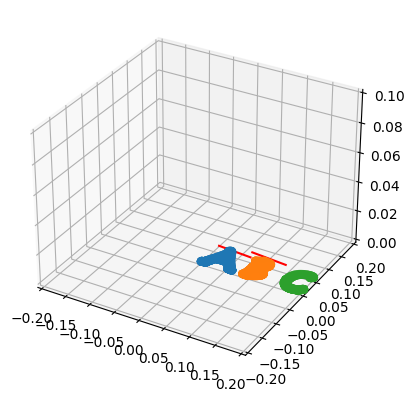

In [156]:
#SVG('Summer 2023/C.svg')

#PointCloud_A = pointcloud
#PointCloud_B = pointcloud
#PointCloud_C = pointcloud

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
        
ax.scatter(PointCloud_A[:,0]*0.0001,PointCloud_A[:,1]*0.0001)
ax.scatter(0.075+PointCloud_B[:,0]*0.0001,PointCloud_B[:,1]*0.0001)
ax.scatter(0.15+PointCloud_C[:,0]*0.0001,PointCloud_C[:,1]*0.0001)

ax.plot([PointCloud_A[-1,0]*0.0001,0.075+PointCloud_B[0,0]*0.0001],
         [PointCloud_A[-1,1]*0.0001,PointCloud_B[0,1]*0.0001],
             [0.01,0.01],color = 'r');

ax.plot([0.075+PointCloud_B[-1,0]*0.0001,0.15+PointCloud_C[0,0]*0.0001],
         [PointCloud_B[-1,1]*0.0001,PointCloud_C[0,1]*0.0001],
             [0.01,0.01],color = 'r');


ax.set_xlim(-0.2,0.2)
ax.set_ylim(-0.2,0.2)
ax.set_zlim(0,0.1)

In [175]:
#PointCloud_A = [PointCloud_A[:,0]*0.0001, PointCloud_A[:,1]*0.0001,np.zeros(len(PointCloud_A))+0.25]
#PointCloud_B = [0.075+PointCloud_B[:,0]*0.0001,PointCloud_B[:,1]*0.0001, np.zeros(len(PointCloud_B))+0.25]
#PointCloud_C = [0.15+PointCloud_C[:,0]*0.0001,PointCloud_C[:,1]*0.0001, np.zeros(len(PointCloud_C))+0.25]

np.array(PointCloud_A)[0,0]
#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
        
#ax.scatter(PointCloud_A[:,0],PointCloud_A[:,1])
#ax.scatter(PointCloud_B[:,0],PointCloud_B[:,1])
#ax.scatter(PointCloud_C[:,0],PointCloud_C[:,1])

0.0432

In [177]:
pointcloud_abc = np.concatenate(( PointCloud_A, 
                                 [[np.array(PointCloud_A)[0,-1],np.array(PointCloud_B)[0,0]],
                                 [np.array(PointCloud_A)[1,-1],np.array(PointCloud_B)[1,0]],
                                 [0.26,0.26]],
                                PointCloud_B,
                                [[np.array(PointCloud_B)[0,-1],np.array(PointCloud_C)[0,0]],
                                 [np.array(PointCloud_B)[1,-1],np.array(PointCloud_C)[1,0]],
                                 [0.26,0.26]],
                                PointCloud_C
                                ), axis=1)
pointcloud_abc.shape


(3, 1904)

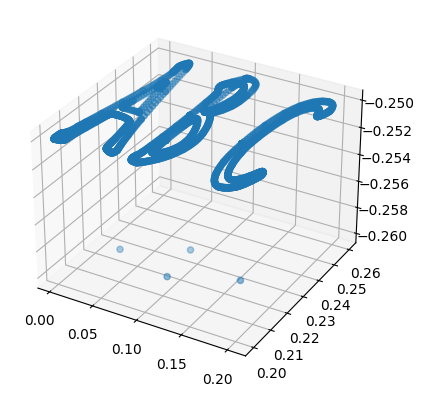

In [230]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
        
ax.scatter(pointcloud_abc[0,:],0.2+pointcloud_abc[1,:],-1*pointcloud_abc[2,:])


# add 0.2 to y axis before inverse Kinematics 

# flip Z axis to negative 


In [115]:
def distF(x, contour_points):
    return np.min(np.linalg.norm(np.subtract(contour_points, np.zeros(contour_points.shape)+x), axis=1))

In [116]:
x_min = int(np.min(pointcloud[:,0]))
x_max = int(np.max(pointcloud[:,0]))
y_min = int(np.min(pointcloud[:,1]))
y_max = int(np.max(pointcloud[:,1]))

#x = np.linspace(x_min, x_max ,num= (x_min+x_max)//8)
#y = np.linspace(y_min, y_max ,num= (y_min+y_max)//8)
#xx, yy = np.meshgrid(x, y, sparse=False)


x = np.linspace(0, 1000, num = 100 , dtype=int)
y = np.linspace(0, 1000, num = 100 , dtype=int)






In [117]:
from fontTools.pens.pointInsidePen import PointInsidePen

def load_glyph(font_file, x):
    # Load the font file
    font = TTFont(font_file)
    glyph_set = font.getGlyphSet()
    return glyph_set[font.getGlyphOrder()[x]]

    
C_glyph = load_glyph(font_file_path, 43)

def is_inside(glyph, xy):
    pen = PointInsidePen(glyph, xy) 
    glyph.draw(pen) 
    isInside = pen.getResult()
    return isInside


1 extra bytes in post.stringData array


In [118]:
import itertools
from scipy import stats
xy = np.array( [ [i,j] for i in x for j in y if is_inside(C_glyph,(i,j))] )
z = np.array( [ int(distF(np.array(k),pointcloud)) for k in xy ])
print(z.shape)



(680,)


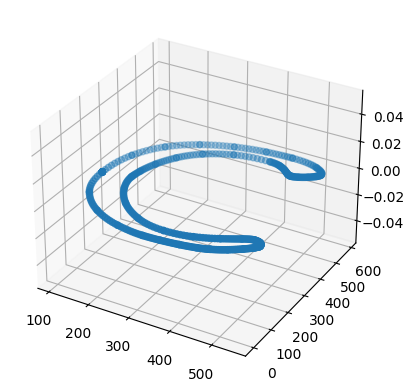

In [121]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

#ax.scatter(xy[:,0],xy[:,1],z, c=z)
        
ax.scatter(pointcloud[:,0],pointcloud[:,1])



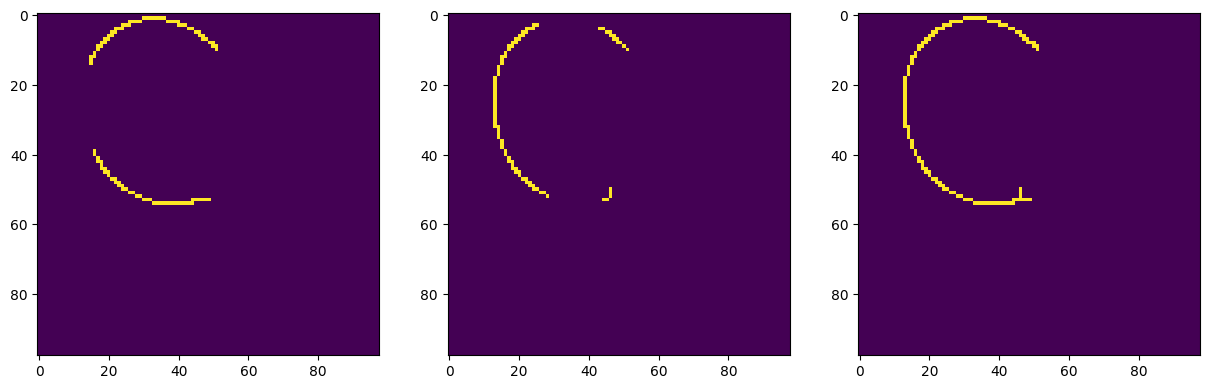

In [120]:
from scipy import signal
from scipy import ndimage
from skimage import feature



zz= np.zeros((1000,1000))
mask = zz
mask[xy[:,0],xy[:,1]] = np.ones(z.shape)
zz[xy[:,0],xy[:,1]] = z


grad = np.gradient(zz[x[1:99],:][:,y[1:99]].T)

cannE = feature.canny((grad[0]+1)*(grad[1]+1) , low_threshold=10, high_threshold= 25, mask=mask[x[1:99],:][:,y[1:99]].T)
cannE0 = feature.canny((grad[0]) , low_threshold=20, high_threshold= 25, mask=mask[x[1:99],:][:,y[1:99]].T)
cannE1 = feature.canny((grad[1]) , low_threshold=20, high_threshold= 25, mask=mask[x[1:99],:][:,y[1:99]].T)



fig = plt.figure(figsize=(15,25))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

#ax.scatter(xy[peaks[0],0],xy[peaks[0],1], c=z[peaks[0]])


#ax.imshow(zz[x[1:49],:][:,y[1:49]].T)
ax1.imshow(cannE0)
ax2.imshow(cannE1)

ax3.imshow(cannE0 | cannE1)

#ax.scatter(pointcloud[:,0],pointcloud[:,1])



In [412]:
from sympy import symbols, pi, sin, cos, simplify, diff
from sympy.matrices import Matrix
from itertools import product as prod

#DH Paramater Creation
def Dh_param_matrix(a, d, Alpha, Nu):
    # a = Link Length, d = Offset, Alpha = Twist, Nu = Joint Angle
    
    return Matrix( [ [cos(Nu),-sin(Nu)*cos(Alpha), sin(Nu)*sin(Alpha),a*cos(Nu)],
                     [sin(Nu), cos(Nu)*cos(Alpha),-cos(Nu)*sin(Alpha),a*sin(Nu)],
                     [0      , sin(Alpha)        , cos(Alpha)        ,d            ],
                     [0      , 0                 , 0                 ,1            ] ] 
                 ); 
  
def Build_arm_6R(nu1,nu2,nu3,nu4,nu5,nu6):
    #Link Length in meters
    a1 = 0; a2 = -0.0054; a3 = 0; a4 = -0.0064; a5 = 0; a6 = 0
    #Offset
    d1 = 0.2648; d2 = 0.1284; d3 = 0.41; d4 = 0.2084; d5 = 0.1059; d6 = 0.1059
    #Twist
    Alpha1 = 0; Alpha2 = pi/2; Alpha3 = pi; Alpha4 = pi/2; Alpha5 = -pi/2; Alpha6 = pi/2
    #Joint Angle
    Nu1 = nu1; Nu2 = nu2; Nu3 = nu3; Nu4 = nu4; Nu5 = nu5; Nu6 = nu6  

    return Dh_param_matrix(a1,d1,Alpha1,Nu1
            )*Dh_param_matrix(a2,d2,Alpha2,Nu2
            )*Dh_param_matrix(a3,d3,Alpha3,Nu3
            )*Dh_param_matrix(a4,d4,Alpha4,Nu4
            )*Dh_param_matrix(a5,d5,Alpha5,Nu5
            )*Dh_param_matrix(a6,d6,Alpha6,Nu6);  
                

In [374]:

# Dataset Generator f 
Nu1, Nu2, Nu3, Nu4, Nu5, Nu6 = symbols('Nu1:7')    
arm = Build_arm_6R(Nu1, Nu2, Nu3, Nu4, Nu5, Nu6)

def arm_gen(x):  
    arm_out = arm.subs({Nu1: x[0], Nu2: x[1], Nu3: x[2], Nu4: x[3], Nu5: x[4], Nu6: x[5]})
    arm_out.row_del(3)
    return arm_out,[x[0],x[1],x[2],x[3],x[4],x[5]]



In [375]:
#testing_inverse = Build_arm_6R(Nu1, Nu2, Nu3, Nu4, Nu5, Nu6)


def Build_Jacobian_6R(nu1,nu2,nu3,nu4,nu5,nu6):
    #Link Length in meters
    a1 = 0; a2 = -0.0054; a3 = 0; a4 = -0.0064; a5 = 0; a6 = 0
    #Offset
    d1 = 0.2648; d2 = 0.1284; d3 = 0.41; d4 = 0.2084; d5 = 0.1059; d6 = 0.1059
    #Twist
    Alpha1 = 0; Alpha2 = pi/2; Alpha3 = pi; Alpha4 = pi/2; Alpha5 = -pi/2; Alpha6 = pi/2
    #Joint Angle
    Nu1 = nu1; Nu2 = nu2; Nu3 = nu3; Nu4 = nu4; Nu5 = nu5; Nu6 = nu6  

    Link_1 = Dh_param_matrix(a1,d1,Alpha1,Nu1)
    Link_2 = Link_1*Dh_param_matrix(a2,d2,Alpha2,Nu2)
    Link_3 = Link_2*Dh_param_matrix(a3,d3,Alpha3,Nu3)
    Link_4 = Link_3*Dh_param_matrix(a4,d4,Alpha4,Nu4)
    Link_5 = Link_4*Dh_param_matrix(a5,d5,Alpha5,Nu5)
    Link_6 = Link_5*Dh_param_matrix(a6,d6,Alpha6,Nu6)
    
    Link_1.row_del(-1)
    Link_2.row_del(-1)
    Link_3.row_del(-1)
    Link_4.row_del(-1)
    Link_5.row_del(-1)
    Link_6.row_del(-1)
    
    Z0 = Matrix([0,0,1])
    Z1 = Link_1.col(2)
    Z2 = Link_2.col(2)
    Z3 = Link_3.col(2)
    Z4 = Link_4.col(2)
    Z5 = Link_5.col(2)
    Z6 = Link_6.col(2)

    P1 = Link_1.col(3)
    P2 = Link_2.col(3)
    P3 = Link_3.col(3)
    P4 = Link_4.col(3)
    P5 = Link_5.col(3)
    P6 = Link_6.col(3)
        
    Jacobian = Matrix(([Z0.cross(P6   ).T,Z0.T],
                       [Z1.cross(P6-P1).T,Z1.T],
                       [Z2.cross(P6-P2).T,Z2.T],
                       [Z3.cross(P6-P3).T,Z3.T],
                       [Z4.cross(P6-P4).T,Z4.T],
                       [Z5.cross(P6-P5).T,Z5.T]))
    
    return Jacobian.T;  



In [440]:
def Build_Jacobian_6R(nu1,nu2,nu3,nu4,nu5,nu6):
    #Link Length in meters
    a1 = 0; a2 = -0.0054; a3 = 0; a4 = -0.0064; a5 = 0; a6 = 0
    #Offset
    d1 = 0.2648; d2 = 0.1284; d3 = 0.41; d4 = 0.2084; d5 = 0.1059; d6 = 0.1059
    #Twist
    Alpha1 = 0; Alpha2 = pi/2; Alpha3 = pi; Alpha4 = pi/2; Alpha5 = -pi/2; Alpha6 = pi/2
    #Joint Angle
    Nu1 = nu1; Nu2 = nu2; Nu3 = nu3; Nu4 = nu4; Nu5 = nu5; Nu6 = nu6  

    Arm = Dh_param_matrix(a1,d1,Alpha1,Nu1)*Dh_param_matrix(a2,d2,Alpha2,Nu2)*Dh_param_matrix(a3,d3,Alpha3,Nu3)*Dh_param_matrix(a4,d4,Alpha4,Nu4)*Dh_param_matrix(a5,d5,Alpha5,Nu5)*Dh_param_matrix(a6,d6,Alpha6,Nu6)
    Arm.row_del(-1)
    
    T=Arm.col(-1)
    Arm.col_del(-1)
    R = Arm
        
    Jp1 = diff(T, nu1) 
    Jp2 = diff(T, nu2) 
    Jp3 = diff(T, nu3) 
    Jp4 = diff(T, nu4) 
    Jp5 = diff(T, nu5) 
    Jp6 = diff(T, nu6) 
    
    Jo1 = diff(R, nu1) * R.T
    Jo2 = diff(R, nu2) * R.T
    Jo3 = diff(R, nu3) * R.T
    Jo4 = diff(R, nu4) * R.T
    Jo5 = diff(R, nu5) * R.T
    Jo6 = diff(R, nu6) * R.T

    
    Jo1 = Matrix([Jo1[2,1],Jo1[0,2],Jo1[1,0]])
    Jo2 = Matrix([Jo2[2,1],Jo2[0,2],Jo2[1,0]])
    Jo3 = Matrix([Jo3[2,1],Jo3[0,2],Jo3[1,0]])
    Jo4 = Matrix([Jo4[2,1],Jo4[0,2],Jo4[1,0]])
    Jo5 = Matrix([Jo5[2,1],Jo5[0,2],Jo5[1,0]])
    Jo6 = Matrix([Jo6[2,1],Jo6[0,2],Jo6[1,0]])

    return Matrix(([Jp1.T,Jo1.T],
                   [Jp2.T,Jo2.T],
                   [Jp3.T,Jo3.T],
                   [Jp4.T,Jo4.T],
                   [Jp5.T,Jo5.T],
                   [Jp6.T,Jo6.T] ))

In [471]:
test_jacobian = Build_Jacobian_6R(Nu1, Nu2, Nu3, Nu4, Nu5, Nu6)


#N = test_jacobian.H * (test_jacobian * test_jacobian.H) ** -1


(3, 3)
(3, 1)
(3, 1)


In [472]:
test_jacobian.T

Matrix([
[                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              0.1059*(sin(Nu1)*sin(Nu2) - cos(Nu1)*cos(Nu2))*cos(Nu5) - 0.0064*(-sin(Nu1)*cos(Nu2) - sin(Nu2)*cos(Nu1))*sin(Nu3)*sin(Nu4) - 0.1059*(-sin(Nu1)*cos(Nu2) - sin(Nu2)*cos(Nu1))*sin(Nu3)*cos(Nu4) + 0.1059*(-sin(Nu1)*cos(Nu2) - sin(Nu2)*cos(Nu1))*sin(Nu4)*cos(Nu3) - 0.0064*(-sin(Nu1)*cos(Nu2) - sin(Nu2)*cos(Nu1))*cos(Nu3)*cos(Nu4) - 0.1059*((-sin(Nu1)*cos(Nu2) - sin(Nu2)*cos(Nu1))*sin(Nu3)*sin(Nu4) + (-sin(Nu1)*cos(Nu2) - sin(Nu2)*cos(Nu1))*cos(Nu3)

In [475]:
tester = test_jacobian.subs({Nu1:np.deg2rad(55), 
                    Nu2:np.deg2rad(15), 
                    Nu3:np.deg2rad(15), 
                    Nu4:np.deg2rad(15), 
                    Nu5:np.deg2rad(55), 
                    Nu6:np.deg2rad(55)})

In [477]:
N = tester.T * (tester * tester.T) ** -1


NonInvertibleMatrixError: Matrix det == 0; not invertible.

In [227]:
# Generating Basic Dataset with no extra Techniques 

#Basic Density
D = 4
n1 = np.linspace(-np.pi/6,np.pi/6,D)
n2 = np.linspace(-np.pi/4,np.pi/4,D)
n3 = np.linspace(-np.pi,np.pi,D)
n4 = np.linspace(-np.pi,np.pi,D)
n5 = np.linspace(-np.pi,np.pi,D)
n6 = np.linspace(-np.pi,np.pi,D)

result, sequence = zip(*[arm_gen(E) for E in list(prod(n1, n2, n3, n4, n5, [0])) ])
print('Completed generating regular density data set with a size of {}x{}. Check -> {}={}'.format(
                                        len(result), result[0].shape, len(result), len(sequence) ) 
     )




Completed generating regular density data set with a size of 1024x(3, 4). Check -> 1024=1024


In [228]:
result = np.array(result)

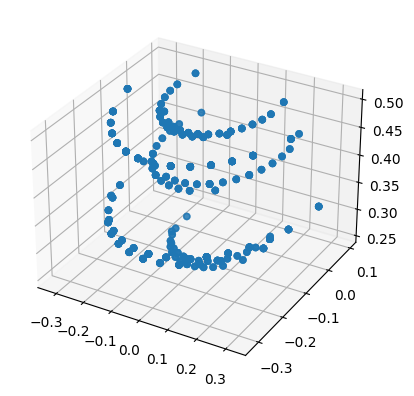

In [229]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
        
ax.scatter(result[:,0,3],result[:,1,3],result[:,2,3])


In [181]:
import ipywidgets as widgets

elev = widgets.FloatSlider(description='elev',min=0,max=90,step=15)
azim = widgets.FloatSlider(description='azim',min=0,max=90,step=15)

Joint_1 = widgets.FloatSlider(description='Joint_1',min=-pi,max=pi,step=pi/24)
Joint_2 = widgets.FloatSlider(description='Joint_2',min=  0,max=pi,step=pi/24)
Joint_3 = widgets.FloatSlider(description='Joint_3',min=-pi,max=pi,step=pi/24)
Joint_4 = widgets.FloatSlider(description='Joint_4',min=-pi,max=pi,step=pi/24)
Joint_5 = widgets.FloatSlider(description='Joint_5',min=-pi,max=pi,step=pi/24)
Joint_6 = widgets.FloatSlider(description='Joint_6',min=-pi,max=pi,step=pi/24)

def f(elevation, azimuth):    
    fig2 = plt.figure(figsize=(20, 15))
    ax2 = plt.axes(projection='3d', elev=elevation, azim=azimuth )
    ax2.scatter3D(result[:,0], result[:,1], result[:,2], c='b');
    #ax2.scatter3D(DF.iloc[:,3], DF.iloc[:,4], DF.iloc[:,5], c='r');
    
def arm_plot(nu1,nu2,nu3,nu4,nu5,nu6, Elev, Azim):
    #result, sequence = arm_gen([nu1,nu2,nu3,nu4,nu5,nu6])
    fig2 = plt.figure(figsize=(10, 10))
    ax2 = plt.axes(projection='3d', elev=Elev, azim=Azim )
    #ax2.scatter3D(result[3], result[7], result[11], c='b');
    
    a1 = 0; a2 = 0.41; a3 = 0.0; a4 = 0.0; a5 = 0.0; a6 = 0.0
    #Offset
    d1 = -(0.15643+0.12838); d2 = -0.00538; d3 = -0.00638; d4 = -(0.20843+0.10593); d5 = 0.0; d6 = -(0.1059+0.06153)
    #Twist
    Alpha1 = pi/2; Alpha2 = pi; Alpha3 = pi/2; Alpha4 =pi/2; Alpha5 = pi/2; Alpha6 = pi
    #Joint Angle
    Nu1 = nu1; Nu2 = nu2-pi/2; Nu3 = nu3-pi/2; Nu4 = nu4+pi; Nu5 = nu5+pi; Nu6 = nu6+pi  
    
    Link_1 = Dh_param_matrix(a1,d1,Alpha1,Nu1)
    Link_2 = Link_1*Dh_param_matrix(a2,d2,Alpha2,Nu2)
    Link_3 = Link_2*Dh_param_matrix(a3,d3,Alpha3,Nu3)
    Link_4 = Link_3*Dh_param_matrix(a4,d4,Alpha4,Nu4)
    Link_5 = Link_4*Dh_param_matrix(a5,d5,Alpha5,Nu5)
    Link_6 = Link_5*Dh_param_matrix(a6,d6,Alpha6,Nu6)     

    ax2.plot([0,Link_1[0,3]],[0,Link_1[1,3]],[0,Link_1[2,3]],color = 'g');
    ax2.plot([Link_1[0,3],Link_2[0,3]],
             [Link_1[1,3],Link_2[1,3]],
             [Link_1[2,3],Link_2[2,3]],color = 'r');
    ax2.plot([Link_2[0,3],Link_3[0,3]],[Link_2[1,3],Link_3[1,3]],[Link_2[2,3],Link_3[2,3]],color = 'y');
    ax2.plot([Link_3[0,3],Link_4[0,3]],[Link_3[1,3],Link_4[1,3]],[Link_3[2,3],Link_4[2,3]],color = 'g');
    ax2.plot([Link_4[0,3],Link_5[0,3]],[Link_4[1,3],Link_5[1,3]],[Link_4[2,3],Link_5[2,3]],color = 'r');
    ax2.plot([Link_5[0,3],Link_6[0,3]],[Link_5[1,3],Link_6[1,3]],[Link_5[2,3],Link_6[2,3]],color = 'y');
    ax2.set_xlim(-0.5,0.5)
    ax2.set_ylim(-0.5,0.5)
    ax2.set_zlim(0,-1)
    
out = widgets.interactive_output(arm_plot, {'nu1':Joint_1,'nu2':Joint_2,'nu3':Joint_3,
                                             'nu4':Joint_4,'nu5':Joint_5,'nu6':Joint_6,
                                           'Elev':elev, 'Azim':azim})

widgets.VBox( [ widgets.HBox([Joint_1, Joint_2, Joint_3]), widgets.HBox([Joint_4, Joint_5, Joint_6]), widgets.HBox([elev, azim]), out ] )


In [105]:
from sympy import N
def arm_print(nu1,nu2,nu3,nu4,nu5,nu6):
    #result, sequence = arm_gen([nu1,nu2,nu3,nu4,nu5,nu6])
    
    a1 = 0; a2 = 0.41; a3 = 0.0; a4 = 0.0; a5 = 0.0; a6 = 0.0
    #Offset
    d1 = -(0.15643+0.12838); d2 = -0.00538; d3 = -0.00638; d4 = -(0.20843+0.10593); d5 = 0.0; d6 = -(0.1059+0.06153)
    #Twist
    Alpha1 = pi/2; Alpha2 = pi; Alpha3 = pi/2; Alpha4 =pi/2; Alpha5 = pi/2; Alpha6 = pi
    #Joint Angle
    Nu1 = nu1; Nu2 = nu2-pi/2; Nu3 = nu3-pi/2; Nu4 = nu4+pi; Nu5 = nu5+pi; Nu6 = nu6+pi  
    
    Link_1 = Dh_param_matrix(a1,d1,Alpha1,Nu1)
    Link_2 = Link_1*Dh_param_matrix(a2,d2,Alpha2,Nu2)
    Link_3 = Link_2*Dh_param_matrix(a3,d3,Alpha3,Nu3)
    Link_4 = Link_3*Dh_param_matrix(a4,d4,Alpha4,Nu4)
    Link_5 = Link_4*Dh_param_matrix(a5,d5,Alpha5,Nu5)
    Link_6 = Link_5*Dh_param_matrix(a6,d6,Alpha6,Nu6)     

    print("Angles : {},{},{},{},{},{}".format(nu1,nu2,nu3,nu4,nu5,nu6))
    
    print("End Effector Location: {},{},{}".format(N(Link_6[0,3], 5), N(Link_6[1,3], 5),N(Link_6[2,3], 5)))
    print("End Effector Orientation  : {} \n\t\t\t    {} \n\t\t\t    {}".format(N(Link_6[0,:3], 5)[:], N(Link_6[1,:3], 5)[:],N(Link_6[2,:3], 5)[:] ))
    
arm_print(np.deg2rad(359.9999), 
          np.deg2rad(15.0064), 
          np.deg2rad(229.9975), 
          np.deg2rad(359.998), 
          np.deg2rad(55.0002), 
          np.deg2rad(89.9993) ) 
    

Angles : 6.283183561850334,0.26191108887127706,4.014213646355659,6.283150400594546,0.9599345792553853,1.5707841094901327
End Effector Location: 0.45386,-0.00099600,-0.42327
End Effector Orientation  : [2.6853e-5, 0.00015184, 1.0000] 
			    [-1.0000, 3.2239e-5, 2.6849e-5] 
			    [-3.2234e-5, -1.0000, 0.00015184]


In [106]:
def print_R33_fromThetaXYZ(x_psi,y_theta,z_phi):
    print("{:.4f}, {:.4f}, {:.4f}".format(
            np.cos(z_phi)*np.cos(y_theta),
                    np.cos(z_phi)*np.sin(y_theta)*np.sin(x_psi) - np.sin(y_theta)*np.cos(x_psi),
                        np.cos(z_phi)*np.sin(y_theta)*np.cos(x_psi) + np.sin(z_phi)*np.sin(x_psi)))
    
    print("{:.4f}, {:.4f}, {:.4f}".format(
            np.sin(z_phi)*np.cos(y_theta),
                np.sin(z_phi)*np.sin(y_theta)*np.sin(x_psi) + np.cos(z_phi)*np.cos(x_psi),
                    np.sin(z_phi)*np.sin(y_theta)*np.cos(x_psi) - np.cos(z_phi)*np.sin(x_psi)))
    
    print("{:.4f}, {:.4f}, {:.4f}".format(-np.sin(y_theta), np.cos(y_theta)*np.sin(x_psi), np.cos(y_theta)*np.cos(x_psi)))

print_R33_fromThetaXYZ(np.deg2rad(89.00),
                       np.deg2rad(1.422),
                       np.deg2rad(90.98))

-0.0171, -0.0009, 0.9997
0.9995, 0.0245, 0.0175
-0.0248, 0.9995, 0.0174


In [ ]:
𝑐𝜙𝑐𝜃 𝑐𝜙𝑠𝜃𝑠𝜓 − 𝑠𝜙𝑐𝜓 𝑐𝜙𝑠𝜃𝑐𝜓 + 𝑠𝜙𝑠𝜓
𝑠𝜙𝑐𝜃 𝑠𝜙𝑠𝜃𝑠𝜓 + 𝑐𝜙𝑐𝜓 𝑠𝜙𝑠𝜃𝑐𝜓 − 𝑐𝜙𝑠𝜓
−𝑠𝜃 𝑐𝜃𝑠𝜓 𝑐𝜃𝑐𝜓